%md
# Bank Churn Classification

- **Danish Muhammad Azhar**
- **Muhammad Murtaza Shafiq**

### 1. Import Libraries

In [0]:
# Import Libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier,GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline

### 2. Import Data

In [0]:
# Create Spark Session
spark = SparkSession.builder.appName('MLlib_Models').getOrCreate()

# Import Data into Data Frames
train = spark.read.csv('/FileStore/train.csv', header=True, inferSchema=True)
test = spark.read.csv('/FileStore/test.csv', header=True, inferSchema=True)

# Save the DataFrames as Parquet files
#train = train.write.parquet('/FileStore/train.parquet', mode='overwrite')
#test = test.write.parquet('/FileStore/test.parquet', mode='overwrite')



In [0]:
train_df=train
test_df=test

### 3. EDA

In [0]:
# Train Data
train_df = spark.read.format("csv")\
                        .option("header", "true")\
                        .option("inferSchema", "true")\
                        .load("/FileStore/train.csv")

In [0]:
# Test Data
test_df = spark.read.format("csv")\
                        .option("header", "true")\
                        .option("inferSchema", "true")\
                        .load("/FileStore/test.csv")

In [0]:
train_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [0]:
test_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)



In [0]:
%sql
CREATE DATABASE IF NOT EXISTS project;
USE project;

In [0]:
train_df.write.mode("overwrite").saveAsTable("project.train")

In [0]:
test_df.write.mode("overwrite").saveAsTable("project.test")

#### Pre-Steps

In [0]:
# Display the first few rows of the DataFrame
train_df.show(5)

+---+----------+--------------+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+
| id|CustomerId|       Surname|CreditScore|Geography|Gender| Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---+----------+--------------+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+
|  0|  15674932|Okwudilichukwu|        668|   France|  Male|33.0|     3|      0.0|            2|      1.0|           0.0|      181449.97|     0|
|  1|  15749177| Okwudiliolisa|        627|   France|  Male|33.0|     1|      0.0|            2|      1.0|           1.0|        49503.5|     0|
|  2|  15694510|         Hsueh|        678|   France|  Male|40.0|    10|      0.0|            2|      1.0|           0.0|      184866.69|     0|
|  3|  15741417|           Kao|        581|   France|  Male|34.0|     2|148882.54|            1|      1.0|           1.0|       84

In [0]:
%sql
-- Display the first few rows of the DataFrame
SELECT * FROM project.train LIMIT 5;

id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.0,2,1.0,1.0,49503.5,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.0,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.0,2,1.0,1.0,15068.83,0


Check Null Values

In [0]:
# Check for null values
from pyspark.sql.functions import col, count, when, isnan

null_counts = train_df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in train_df.columns])
null_counts.show()

+---+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
| id|CustomerId|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|  0|         0|      0|          0|        0|     0|  0|     0|      0|            0|        0|             0|              0|     0|
+---+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+



In [0]:
# Get the shape of the DataFrame
print(f"Number of rows: {train_df.count()}")
print(f"Number of columns: {len(train_df.columns)}")

Number of rows: 165034
Number of columns: 14


In [0]:
# Display DataFrame schema and basic information
train_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [0]:
# Get unique values in the 'Geography' column
train_df.select('Geography').distinct().show()

+---------+
|Geography|
+---------+
|  Germany|
|   France|
|    Spain|
+---------+



Generate Descriptive Statistics

In [0]:
# Generate descriptive statistics for numeric columns
train_df.describe().show()

+-------+---------------+--------------------+-------+----------------+---------+------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+
|summary|             id|          CustomerId|Surname|     CreditScore|Geography|Gender|              Age|            Tenure|           Balance|     NumOfProducts|         HasCrCard|     IsActiveMember|   EstimatedSalary|             Exited|
+-------+---------------+--------------------+-------+----------------+---------+------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+
|  count|         165034|              165034| 165034|          165034|   165034|165034|           165034|            165034|            165034|            165034|            165034|             165034|            165034|             165034|
|   mean|        82516.5|1.56920

In [0]:
%sql
-- Generate descriptive statistics for numeric columns
SELECT 
  AVG(CreditScore) AS avg_credit_score,
  MIN(CreditScore) AS min_credit_score,
  MAX(CreditScore) AS max_credit_score,
  AVG(Age) AS avg_age,
  MIN(Age) AS min_age,
  MAX(Age) AS max_age,
  AVG(Tenure) AS avg_tenure,
  MIN(Tenure) AS min_tenure,
  MAX(Tenure) AS max_tenure,
  AVG(Balance) AS avg_balance,
  MIN(Balance) AS min_balance,
  MAX(Balance) AS max_balance,
  AVG(NumOfProducts) AS avg_num_products,
  MIN(NumOfProducts) AS min_num_products,
  MAX(NumOfProducts) AS max_num_products,
  AVG(EstimatedSalary) AS avg_estimated_salary,
  MIN(EstimatedSalary) AS min_estimated_salary,
  MAX(EstimatedSalary) AS max_estimated_salary
FROM project.train;

avg_credit_score,min_credit_score,max_credit_score,avg_age,min_age,max_age,avg_tenure,min_tenure,max_tenure,avg_balance,min_balance,max_balance,avg_num_products,min_num_products,max_num_products,avg_estimated_salary,min_estimated_salary,max_estimated_salary
656.454373038283,350,850,38.12588787764945,18.0,92.0,5.020353381727402,0,10,55478.086689349235,0.0,250898.09,1.5544554455445545,1,4,112574.82273434362,11.58,199992.48


Analysis Point #1: What is the overall distribution of credit scores among customers, and are there any noticeable patterns or outliers?

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

# Distribution of Credit Scores
credit_score_hist = train_df.select(F.col("CreditScore").cast(IntegerType()))
credit_score_hist.summary().show()
credit_score_hist.createOrReplaceTempView("credit_score")
spark.sql("SELECT CreditScore, COUNT(*) as count FROM credit_score GROUP BY CreditScore ORDER BY CreditScore").show()

+-------+----------------+
|summary|     CreditScore|
+-------+----------------+
|  count|          165034|
|   mean|656.454373038283|
| stddev|80.1033404871783|
|    min|             350|
|    25%|             597|
|    50%|             659|
|    75%|             710|
|    max|             850|
+-------+----------------+

+-----------+-----+
|CreditScore|count|
+-----------+-----+
|        350|   19|
|        358|    1|
|        359|    2|
|        363|    4|
|        365|    6|
|        367|    8|
|        373|    1|
|        376|    7|
|        382|    2|
|        383|    2|
|        386|    1|
|        399|    3|
|        401|    2|
|        404|    4|
|        405|   10|
|        408|    8|
|        410|    4|
|        411|   28|
|        412|    3|
|        413|    8|
+-----------+-----+
only showing top 20 rows



In [0]:
%sql
-- Distribution of Credit Scores
SELECT CreditScore, COUNT(*) AS count 
FROM project.train 
GROUP BY CreditScore 
ORDER BY CreditScore;

CreditScore,count
350,19
358,1
359,2
363,4
365,6
367,8
373,1
376,7
382,2
383,2


Analysis Point #2: How are customers distributed across different age groups, and do certain age ranges dominate the dataset?

In [0]:
# Age Distribution
age_hist = train_df.select(F.col("Age").cast(IntegerType()))
age_hist.summary().show()
age_hist.createOrReplaceTempView("age")
spark.sql("SELECT Age, COUNT(*) as count FROM age GROUP BY Age ORDER BY Age").show()

+-------+-----------------+
|summary|              Age|
+-------+-----------------+
|  count|           165034|
|   mean|38.12588315135063|
| stddev|8.867206548242015|
|    min|               18|
|    25%|               32|
|    50%|               37|
|    75%|               42|
|    max|               92|
+-------+-----------------+

+---+-----+
|Age|count|
+---+-----+
| 18|  118|
| 19|  214|
| 20|  336|
| 21|  593|
| 22|  933|
| 23| 1172|
| 24| 1620|
| 25| 2107|
| 26| 2682|
| 27| 2908|
| 28| 4412|
| 29| 6439|
| 30| 5335|
| 31| 7093|
| 32| 7713|
| 33| 8367|
| 34| 8625|
| 35| 9118|
| 36| 8557|
| 37| 9255|
+---+-----+
only showing top 20 rows



In [0]:
%sql
-- Age Distribution
SELECT Age, COUNT(*) AS count 
FROM project.train 
GROUP BY Age 
ORDER BY Age;

Age,count
18.0,118
19.0,214
20.0,336
21.0,593
22.0,933
23.0,1172
24.0,1620
25.0,2107
26.0,2682
27.0,2908


Analysis Point #3: What is the Distribution of Balance?

In [0]:
%sql
-- Balance Distribution
SELECT Balance, COUNT(*) AS count 
FROM project.train 
GROUP BY Balance 
ORDER BY Balance;

Balance,count
0.0,89648
18.33,1
3768.69,3
9053.36,1
9904.42,1
10196.67,1
11067.39,1
12459.19,3
12980.53,1
13898.3,1


Analysis Point #4: Which geographical regions have the highest and lowest customer counts, and how does customer distribution vary by geography?

In [0]:
%sql
-- Customer Count by Geography
SELECT Geography, COUNT(*) as count
FROM project.train
GROUP BY Geography
ORDER BY Geography;

Geography,count
France,94215
Germany,34606
Spain,36213


Analysis Point #5: What is the customer Count by Gender

In [0]:
%sql
-- Customer Count by Gender
SELECT Gender, COUNT(*) as count
FROM project.train
GROUP BY Gender
ORDER BY Gender;

Gender,count
Female,71884
Male,93150


Analysis Point #6: Keeping the churn count in consideration, what proportion of customers have stayed versus left the bank?

In [0]:
%sql
-- Churn Distribution
SELECT Exited, COUNT(*) as count
FROM project.train
GROUP BY Exited
ORDER BY Exited;

Exited,count
0,130113
1,34921


Analysis Point #7: How does the distribution of age vary between churned and non-churned customers, and are there significant differences in age ranges?

In [0]:
%sql
-- Age vs. Churn
SELECT Exited, 
       MIN(Age) as min_age, 
       PERCENTILE_APPROX(Age, 0.25) as q1_age,
       PERCENTILE_APPROX(Age, 0.5) as median_age,
       PERCENTILE_APPROX(Age, 0.75) as q3_age,
       MAX(Age) as max_age
FROM project.train
GROUP BY Exited
ORDER BY Exited;


Exited,min_age,q1_age,median_age,q3_age,max_age
0,18.0,31.0,36.0,40.0,92.0
1,18.0,38.0,44.0,50.0,92.0


In [0]:
%sql
-- Query for Age vs Churn
SELECT Exited, Age
FROM project.train;

Exited,Age
0,33.0
0,33.0
0,40.0
0,34.0
0,33.0
1,36.0
0,30.0
0,37.0
0,43.0
0,40.0


Analysis Point #8: What is the relationship between account balance and churn, and how do the distributions of balances differ for churned versus non-churned customers?

In [0]:
%sql
-- Balance vs. Churn
SELECT Exited, 
       MIN(Balance) as min_balance, 
       PERCENTILE_APPROX(Balance, 0.25) as q1_balance,
       PERCENTILE_APPROX(Balance, 0.5) as median_balance,
       PERCENTILE_APPROX(Balance, 0.75) as q3_balance,
       MAX(Balance) as max_balance
FROM project.train
GROUP BY Exited
ORDER BY Exited;

Exited,min_balance,q1_balance,median_balance,q3_balance,max_balance
0,0.0,0.0,0.0,116822.7,250898.09
1,0.0,0.0,98955.87,125427.39,238387.56


In [0]:
%sql
-- Query for Balance vs Churn
SELECT Exited, Balance
FROM project.train;

Exited,Balance
0,0.0
0,0.0
0,0.0
0,148882.54
0,0.0
1,131778.58
0,144772.69
0,138476.41
0,0.0
0,81274.33


Analysis Point #9: How does the distribution of credit scores differ between churned and non-churned customers, and are there any noticeable variations in the spread or central tendency?

In [0]:
%sql
-- Credit Score Distribution for Churned & Non-Churned Customers
SELECT Exited, 
       MIN(CreditScore) as min_credit_score, 
       PERCENTILE_APPROX(CreditScore, 0.25) as q1_credit_score,
       PERCENTILE_APPROX(CreditScore, 0.5) as median_credit_score,
       PERCENTILE_APPROX(CreditScore, 0.75) as q3_credit_score,
       MAX(CreditScore) as max_credit_score
FROM project.train
GROUP BY Exited
ORDER BY Exited;

Exited,min_credit_score,q1_credit_score,median_credit_score,q3_credit_score,max_credit_score
0,350,599,662,711,850
1,350,593,651,708,850


In [0]:
%sql
SELECT Exited, CreditScore
FROM project.train;

Exited,CreditScore
0,668
0,627
0,678
0,581
0,716
1,588
0,593
0,678
0,676
0,583


Analysis Point #10: How does the number of products a customer has relate to their likelihood of churning? (Count of Products vs. Churn)

In [0]:
%sql
SELECT NumOfProducts, Exited, COUNT(*) AS count
FROM project.train
GROUP BY NumOfProducts, Exited
ORDER BY NumOfProducts;

NumOfProducts,Exited,count
1,0,50516
1,1,26858
2,1,5093
2,0,79198
3,1,2554
3,0,340
4,0,59
4,1,416


Analysis Point #11: Are active members less likely to churn compared to inactive members (Churn vs Active Members)

In [0]:
%sql
SELECT IsActiveMember, Exited, COUNT(*) AS count
FROM project.train
GROUP BY IsActiveMember, Exited
ORDER BY IsActiveMember;

IsActiveMember,Exited,count
0.0,0,58261
0.0,1,24624
1.0,0,71852
1.0,1,10297


Analysis Point #12: Does churn behavior vary significantly by geography, and which regions have higher churn rates?

In [0]:
%sql
SELECT Geography, Exited, COUNT(*) AS count
FROM project.train
GROUP BY Geography, Exited
ORDER BY Geography;

Geography,Exited,count
France,0,78643
France,1,15572
Germany,0,21492
Germany,1,13114
Spain,0,29978
Spain,1,6235


Analysis Point #13: What is the maximum number of bank products held by any customer?

In [0]:
max_products = train_df.agg(F.max("NumOfProducts")).collect()[0][0]
print(f"Maximum number of bank products: {max_products}")

Maximum number of bank products: 4


Analysis Point #14: What are the Minimum and maximum salary estimates?

In [0]:
%sql
SELECT 
    MIN(EstimatedSalary) AS min_salary,
    MAX(EstimatedSalary) AS max_salary
FROM project.train;

min_salary,max_salary
11.58,199992.48


Analysis Point #15: How are estimated salaries distributed among customers, and are there any notable trends or outliers in income levels?

In [0]:
%sql
SELECT 
    ROUND(EstimatedSalary, -3) AS SalaryBucket,
    COUNT(*) AS Count
FROM project.train
GROUP BY SalaryBucket
ORDER BY SalaryBucket;

SalaryBucket,Count
0.0,155
1000.0,1187
2000.0,648
3000.0,297
4000.0,408
5000.0,385
6000.0,414
7000.0,302
8000.0,269
9000.0,474


Analysis Point #16: How are credit scores distributed across predefined bins (e.g., Poor, Fair, Good), and which bin has the highest concentration of customers?

In [0]:
%sql
-- Create credit score bins
WITH credit_score_bins AS (
  SELECT 
    CASE 
      WHEN CreditScore < 580 THEN 'Poor (300-579)'
      WHEN CreditScore BETWEEN 580 AND 669 THEN 'Fair (580-669)'
      WHEN CreditScore BETWEEN 670 AND 739 THEN 'Good (670-739)'
      WHEN CreditScore BETWEEN 740 AND 799 THEN 'Very Good (740-799)'
      ELSE 'Excellent (800-850)'
    END AS CreditScoreBin,
    CreditScore
  FROM project.train
)

-- Calculate distribution
SELECT 
  CreditScoreBin,
  COUNT(*) AS Count,
  ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) AS Percentage
FROM credit_score_bins
GROUP BY CreditScoreBin
ORDER BY CreditScoreBin

CreditScoreBin,Count,Percentage
Excellent (800-850),6633,4.02
Fair (580-669),62023,37.58
Good (670-739),52161,31.61
Poor (300-579),27860,16.88
Very Good (740-799),16357,9.91


Analysis Point #17: What is the relationship between credit score and account balance, and do higher credit scores correlate with larger balances?

In [0]:
%sql
SELECT 
  CASE 
    WHEN CreditScore < 580 THEN 'Poor (300-579)'
    WHEN CreditScore BETWEEN 580 AND 669 THEN 'Fair (580-669)'
    WHEN CreditScore BETWEEN 670 AND 739 THEN 'Good (670-739)'
    WHEN CreditScore BETWEEN 740 AND 799 THEN 'Very Good (740-799)'
    ELSE 'Excellent (800-850)'
  END AS CreditScoreBin,
  AVG(Balance) AS AverageBalance,
  COUNT(*) AS CustomerCount
FROM project.train
GROUP BY 
  CASE 
    WHEN CreditScore < 580 THEN 'Poor (300-579)'
    WHEN CreditScore BETWEEN 580 AND 669 THEN 'Fair (580-669)'
    WHEN CreditScore BETWEEN 670 AND 739 THEN 'Good (670-739)'
    WHEN CreditScore BETWEEN 740 AND 799 THEN 'Very Good (740-799)'
    ELSE 'Excellent (800-850)'
  END
ORDER BY CreditScoreBin


CreditScoreBin,AverageBalance,CustomerCount
Excellent (800-850),59168.45676616907,6633
Fair (580-669),55630.95108508123,62023
Good (670-739),53044.738921224554,52161
Poor (300-579),56143.52879791812,27860
Very Good (740-799),60028.26720242105,16357


Analysis Point #18: How does a customer's credit score influence their likelihood of churning, and are lower credit scores associated with higher churn rates?

In [0]:
%sql
SELECT 
  CASE 
    WHEN CreditScore < 580 THEN 'Poor (300-579)'
    WHEN CreditScore BETWEEN 580 AND 669 THEN 'Fair (580-669)'
    WHEN CreditScore BETWEEN 670 AND 739 THEN 'Good (670-739)'
    WHEN CreditScore BETWEEN 740 AND 799 THEN 'Very Good (740-799)'
    ELSE 'Excellent (800-850)'
  END AS CreditScoreBin,
  AVG(CreditScore) AS AvgCreditScore,
  SUM(CASE WHEN Exited = 1 THEN 1 ELSE 0 END) AS ChurnCount,
  COUNT(*) AS TotalCustomers,
  ROUND(SUM(CASE WHEN Exited = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS ChurnRate
FROM project.train
GROUP BY 
  CASE 
    WHEN CreditScore < 580 THEN 'Poor (300-579)'
    WHEN CreditScore BETWEEN 580 AND 669 THEN 'Fair (580-669)'
    WHEN CreditScore BETWEEN 670 AND 739 THEN 'Good (670-739)'
    WHEN CreditScore BETWEEN 740 AND 799 THEN 'Very Good (740-799)'
    ELSE 'Excellent (800-850)'
  END
ORDER BY CreditScoreBin


CreditScoreBin,AvgCreditScore,ChurnCount,TotalCustomers,ChurnRate
Excellent (800-850),832.0367857681291,1352,6633,20.38
Fair (580-669),626.1170533511762,13580,62023,21.90
Good (670-739),701.6594965587316,9969,52161,19.11
Poor (300-579),535.8956209619527,6553,27860,23.52
Very Good (740-799),761.4733753133215,3467,16357,21.20


Analysis Point #19: What are the correlations between key features (e.g., Credit Score, Age, Balance) in the dataset, as visualized in a heatmap, and which features show strong relationships with each other or with churn behavior?

In [0]:
%sql
SELECT 'CreditScore' AS Feature1, 'Age' AS Feature2, CORR(CreditScore, Age) AS Correlation FROM project.train
UNION ALL
SELECT 'CreditScore', 'Balance', CORR(CreditScore, Balance) FROM project.train
UNION ALL
SELECT 'CreditScore', 'EstimatedSalary', CORR(CreditScore, EstimatedSalary) FROM project.train
UNION ALL
SELECT 'CreditScore', 'Tenure', CORR(CreditScore, Tenure) FROM project.train
UNION ALL
SELECT 'CreditScore', 'Exited', CORR(CreditScore, Exited) FROM project.train
UNION ALL
SELECT 'Age', 'Balance', CORR(Age, Balance) FROM project.train
UNION ALL
SELECT 'Age', 'EstimatedSalary', CORR(Age, EstimatedSalary) FROM project.train
UNION ALL
SELECT 'Age', 'Tenure', CORR(Age, Tenure) FROM project.train
UNION ALL
SELECT 'Age', 'Exited', CORR(Age, Exited) FROM project.train
UNION ALL
SELECT 'Balance', 'EstimatedSalary', CORR(Balance, EstimatedSalary) FROM project.train
UNION ALL
SELECT 'Balance', 'Tenure', CORR(Balance, Tenure) FROM project.train
UNION ALL
SELECT 'Balance', 'Exited', CORR(Balance, Exited) FROM project.train
UNION ALL
SELECT 'EstimatedSalary', 'Tenure', CORR(EstimatedSalary, Tenure) FROM project.train
UNION ALL
SELECT 'EstimatedSalary', 'Exited', CORR(EstimatedSalary, Exited) FROM project.train
UNION ALL
SELECT 'Tenure', 'Exited', CORR(Tenure, Exited) FROM project.train;


Feature1,Feature2,Correlation
CreditScore,Age,-0.0089181457710969
CreditScore,Balance,0.00697305349780814
CreditScore,EstimatedSalary,-0.0018203034630182486
CreditScore,Tenure,9.424798875311611E-4
CreditScore,Exited,-0.027382600061651295
Age,Balance,0.06431828654941851
Age,EstimatedSalary,-0.005398663365226519
Age,Tenure,-0.010830345065275875
Age,Exited,0.34076816340758026
Balance,EstimatedSalary,0.008586201180840003


Using Python for better visuals

In [0]:
correlation_results = spark.sql("""
    SELECT 'CreditScore' AS Feature1, 'Age' AS Feature2, CORR(CreditScore, Age) AS Correlation FROM project.train
UNION ALL
SELECT 'CreditScore', 'Balance', CORR(CreditScore, Balance) FROM project.train
UNION ALL
SELECT 'CreditScore', 'EstimatedSalary', CORR(CreditScore, EstimatedSalary) FROM project.train
UNION ALL
SELECT 'CreditScore', 'Tenure', CORR(CreditScore, Tenure) FROM project.train
UNION ALL
SELECT 'CreditScore', 'Exited', CORR(CreditScore, Exited) FROM project.train
UNION ALL
SELECT 'Age', 'Balance', CORR(Age, Balance) FROM project.train
UNION ALL
SELECT 'Age', 'EstimatedSalary', CORR(Age, EstimatedSalary) FROM project.train
UNION ALL
SELECT 'Age', 'Tenure', CORR(Age, Tenure) FROM project.train
UNION ALL
SELECT 'Age', 'Exited', CORR(Age, Exited) FROM project.train
UNION ALL
SELECT 'Balance', 'EstimatedSalary', CORR(Balance, EstimatedSalary) FROM project.train
UNION ALL
SELECT 'Balance', 'Tenure', CORR(Balance, Tenure) FROM project.train
UNION ALL
SELECT 'Balance', 'Exited', CORR(Balance, Exited) FROM project.train
UNION ALL
SELECT 'EstimatedSalary', 'Tenure', CORR(EstimatedSalary, Tenure) FROM project.train
UNION ALL
SELECT 'EstimatedSalary', 'Exited', CORR(EstimatedSalary, Exited) FROM project.train
UNION ALL
SELECT 'Tenure', 'Exited', CORR(Tenure, Exited) FROM project.train
""").toPandas()

In [0]:
correlation_matrix = correlation_results.pivot(index='Feature1', columns='Feature2', values='Correlation')

# Fill diagonal with 1s (self-correlation)
for feature in correlation_matrix.index:
    correlation_matrix.loc[feature, feature] = 1.0

# Fill NaN values with 0 (if any)
correlation_matrix = correlation_matrix.fillna(0)


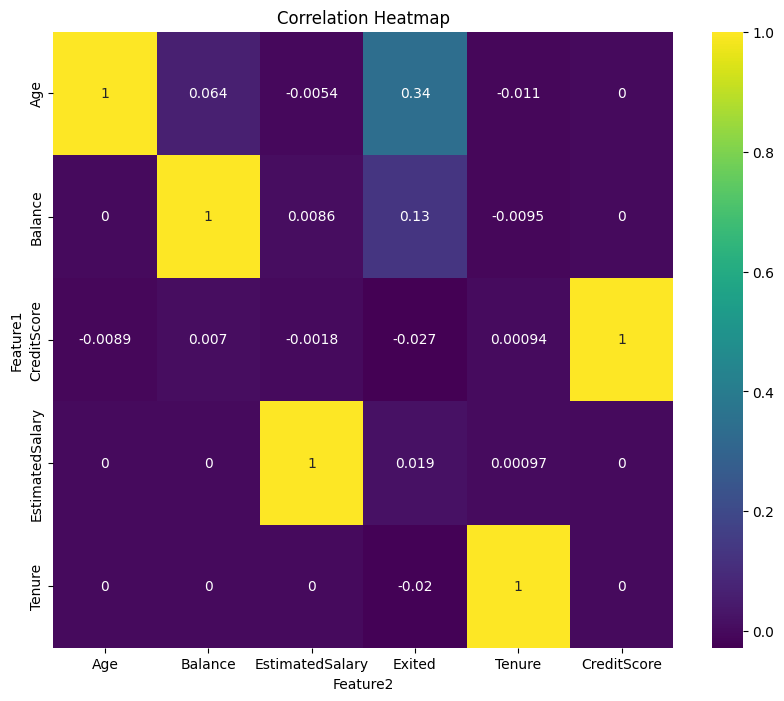

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.astype(float), annot=True, cmap='viridis')
plt.title('Correlation Heatmap')
plt.show()

### 4. Preprocessing

In [0]:
train_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [0]:
train_df.show(5)

+---+----------+--------------+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+
| id|CustomerId|       Surname|CreditScore|Geography|Gender| Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---+----------+--------------+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+
|  0|  15674932|Okwudilichukwu|        668|   France|  Male|33.0|     3|      0.0|            2|      1.0|           0.0|      181449.97|     0|
|  1|  15749177| Okwudiliolisa|        627|   France|  Male|33.0|     1|      0.0|            2|      1.0|           1.0|        49503.5|     0|
|  2|  15694510|         Hsueh|        678|   France|  Male|40.0|    10|      0.0|            2|      1.0|           0.0|      184866.69|     0|
|  3|  15741417|           Kao|        581|   France|  Male|34.0|     2|148882.54|            1|      1.0|           1.0|       84

In [0]:
train_df.columns

['id',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [0]:
import pandas as pd

# Convert Spark DataFrame summary to Pandas
summary_df = train_df.summary().toPandas()

# Display as a table
from IPython.display import display
display(summary_df)

,summary,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,count,165034,165034,165034,165034,165034,165034,165034,165034,165034,165034,165034,165034,165034,165034
1,mean,82516.5,1.5692005019026382E7,None,656.454373038283,None,None,38.12588787764945,5.020353381727402,55478.086689349235,1.5544554455445545,0.7539537307463916,0.49777015645260975,112574.82273434362,0.21159882206090866
2,stddev,47641.356500069,71397.81679067112,None,80.1033404871783,None,None,8.867204591410792,2.8061585665860913,62817.66327783688,0.5471536788441764,0.4307071240449495,0.49999654260421705,50292.865584904175,0.4084431067117287
3,min,0,15565701,Abazu,350,France,Female,18.0,0,0.0,1,0.0,0.0,11.58,0
4,25%,41254,15633112,None,597,None,None,32.0,3,0.0,1,1.0,0.0,74637.57,0
5,50%,82503,15690164,None,659,None,None,37.0,5,0.0,2,1.0,0.0,117946.3,0
6,75%,123774,15756821,None,710,None,None,42.0,7,119919.12,2,1.0,1.0,155061.97,0
7,max,165033,15815690,Zuyeva,850,Spain,Male,92.0,10,250898.09,4,1.0,1.0,199992.48,1


In [0]:
from pyspark.sql.functions import col, isnan, when, count

# Count missing values per column
train_df.select([count(when(col(c).isNull(), c)).alias(c) for c in train_df.columns]).show()

+---+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
| id|CustomerId|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|  0|         0|      0|          0|        0|     0|  0|     0|      0|            0|        0|             0|              0|     0|
+---+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+



### 5. Modelling

In [0]:
# Step 3: Define Preprocessing Pipeline
# Index categorical columns
indexer_geo = StringIndexer(inputCol='Geography', outputCol='GeographyIndex')
indexer_gender = StringIndexer(inputCol='Gender', outputCol='GenderIndex')

# Assemble features into a single vector column
feature_cols = ['CreditScore', 'GeographyIndex', 'GenderIndex', 'Age', 'Tenure', 'Balance',
                'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Create the preprocessing pipeline
preprocessing_pipeline = Pipeline(stages=[indexer_geo, indexer_gender, assembler])

# Step 4: Fit and Transform Data
preprocessed_model = preprocessing_pipeline.fit(train)
train_data = preprocessed_model.transform(train)
test_data = preprocessed_model.transform(test)

# Step 5: Split Data into Training and Validation Sets
train_split, validate_split = train_data.randomSplit([0.7, 0.3], seed=28)

# Print Schema to Verify Transformation
train_split.printSchema()

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

root
 |-- id: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)
 |-- GeographyIndex: double (nullable = false)
 |-- GenderIndex: double (nullable = false)
 |-- features: vector (nullable = true)



In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    LogisticRegression,
    RandomForestClassifier,
    DecisionTreeClassifier,
    GBTClassifier,
    LinearSVC,
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

# Define evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Exited", metricName="accuracy")
auc_evaluator = BinaryClassificationEvaluator(labelCol="Exited", metricName="areaUnderROC")

def create_pipeline(model):
    """
    Create a pipeline that includes only the model (preprocessing is already done).
    
    Parameters:
        model: The machine learning model to include in the pipeline.
    
    Returns:
        A PySpark Pipeline object.
    """
    return Pipeline(stages=[model])

def train_and_evaluate_pipeline(pipeline, train_data, validate_data, param_grid=None):
    """
    Train the given pipeline (with optional hyperparameter tuning), make predictions, and evaluate its performance.

    Parameters:
        pipeline: The PySpark Pipeline object.
        train_data: The training dataset.
        validate_data: The validation dataset.
        param_grid: Optional parameter grid for hyperparameter tuning (default: None).

    Returns:
        A dictionary containing accuracy, AUC-ROC scores, and the trained model.
    """
    # If a parameter grid is provided, use TrainValidationSplit for hyperparameter tuning
    if param_grid:
        evaluator = BinaryClassificationEvaluator(labelCol="Exited", metricName="areaUnderROC")
        tvs = TrainValidationSplit(
            estimator=pipeline,
            estimatorParamMaps=param_grid,
            evaluator=evaluator,
            trainRatio=0.8,  # Use 80% training data for validation
        )
        trained_pipeline = tvs.fit(train_data).bestModel
    else:
        # Train the pipeline without hyperparameter tuning
        trained_pipeline = pipeline.fit(train_data)

    # Make predictions on the validation set
    predictions = trained_pipeline.transform(validate_data)

    # Evaluate the model
    accuracy = accuracy_evaluator.evaluate(predictions)
    auc = auc_evaluator.evaluate(predictions)

    return {
        "model": trained_pipeline,
        "predictions": predictions,
        "accuracy": accuracy,
        "auc": auc,
    }

In [0]:
# Logistic Regression
lr = LogisticRegression(labelCol="Exited", featuresCol="features")
lr_pipeline = create_pipeline(lr)
lr_results = train_and_evaluate_pipeline(lr_pipeline, train_split, validate_split)

print(f"Logistic Regression Accuracy: {lr_results['accuracy']:.2f}")
print(f"Logistic Regression AUC: {lr_results['auc']:.2f}")

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Logistic Regression Accuracy: 0.83
Logistic Regression AUC: 0.81


In [0]:
# Random Forest with Hyperparameter Tuning
rfc = RandomForestClassifier(labelCol="Exited", featuresCol="features")
param_grid_rfc = (
    ParamGridBuilder()
    .addGrid(rfc.numTrees, [100, 150])
    .addGrid(rfc.maxDepth, [10])
    .addGrid(rfc.minInstancesPerNode, [1])
    .addGrid(rfc.featureSubsetStrategy, ["sqrt"])
    .build()
)
rfc_pipeline = create_pipeline(rfc)
rfc_results = train_and_evaluate_pipeline(rfc_pipeline, train_split, validate_split, param_grid=param_grid_rfc)

print(f"Random Forest Accuracy: {rfc_results['accuracy']:.2f}")
print(f"Random Forest AUC: {rfc_results['auc']:.2f}")


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Random Forest Accuracy: 0.86
Random Forest AUC: 0.88


In [0]:
# Decision Tree with Hyperparameter Tuning
dtc = DecisionTreeClassifier(labelCol="Exited", featuresCol="features")
param_grid_dtc = (
    ParamGridBuilder()
    .addGrid(dtc.maxDepth, [5, 10])
    .addGrid(dtc.minInstancesPerNode, [1, 2])
    .addGrid(dtc.impurity, ["gini"])
    .build()
)
dtc_pipeline = create_pipeline(dtc)
dtc_results = train_and_evaluate_pipeline(dtc_pipeline, train_split, validate_split, param_grid=param_grid_dtc)

print(f"Decision Tree Accuracy: {dtc_results['accuracy']:.2f}")
print(f"Decision Tree AUC: {dtc_results['auc']:.2f}")


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Decision Tree Accuracy: 0.86
Decision Tree AUC: 0.60


In [0]:
# Gradient Boosted Trees with Hyperparameter Tuning
gbt = GBTClassifier(labelCol="Exited", featuresCol="features")
param_grid_gbt = (
    ParamGridBuilder()
    .addGrid(gbt.maxDepth, [5, 7])
    .addGrid(gbt.maxIter, [20, 30])
    .addGrid(gbt.stepSize, [0.05, 0.1])
    .build()
)
gbt_pipeline = create_pipeline(gbt)
gbt_results = train_and_evaluate_pipeline(gbt_pipeline, train_split, validate_split, param_grid=param_grid_gbt)

print(f"Gradient Boosted Trees Accuracy: {gbt_results['accuracy']:.2f}")
print(f"Gradient Boosted Trees AUC: {gbt_results['auc']:.2f}")

Gradient Boosted Trees Accuracy: 0.86
Gradient Boosted Trees AUC: 0.88


In [0]:
# Linear Support Vector Machine (No Hyperparameter Tuning)
lsvc = LinearSVC(labelCol="Exited", featuresCol="features", maxIter=10, regParam=0.1)
lsvc_pipeline = create_pipeline(lsvc)
lsvc_results = train_and_evaluate_pipeline(lsvc_pipeline, train_split, validate_split)

print(f"Linear SVM Accuracy: {lsvc_results['accuracy']:.2f}")
print(f"Linear SVM AUC: {lsvc_results['auc']:.2f}")

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Linear SVM Accuracy: 0.79
Linear SVM AUC: 0.81


### 5. Model Evaluation

In [0]:
import pandas as pd

# Collect results into a list of dictionaries
results = [
    {"Model": "Logistic Regression", "Accuracy": lr_results["accuracy"], "AUC": lr_results["auc"]},
    {"Model": "Random Forest", "Accuracy": rfc_results["accuracy"], "AUC": rfc_results["auc"]},
    {"Model": "Decision Tree", "Accuracy": dtc_results["accuracy"], "AUC": dtc_results["auc"]},
    {"Model": "Gradient Boosted Trees", "Accuracy": gbt_results["accuracy"], "AUC": gbt_results["auc"]},
    {"Model": "Linear SVM", "Accuracy": lsvc_results["accuracy"], "AUC": lsvc_results["auc"]},
]

# Convert to Pandas DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df)


                    Model  Accuracy       AUC
0     Logistic Regression  0.831127  0.809820
1           Random Forest  0.863894  0.883583
2           Decision Tree  0.859097  0.598012
3  Gradient Boosted Trees  0.863206  0.884361
4              Linear SVM  0.788160  0.808406


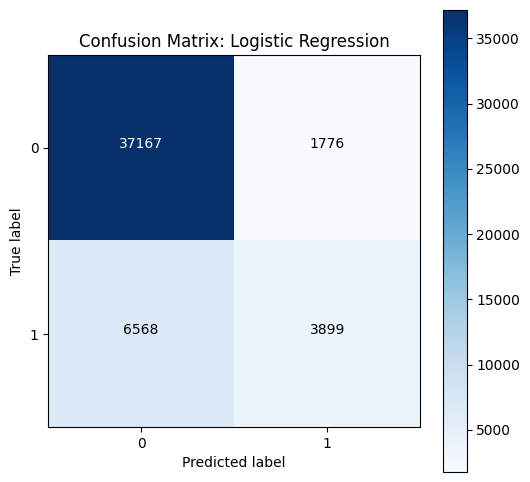

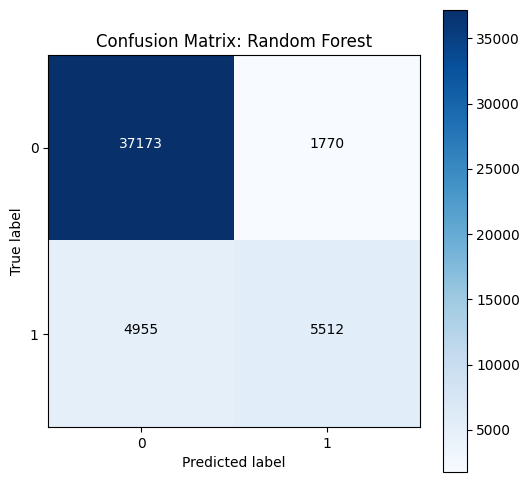

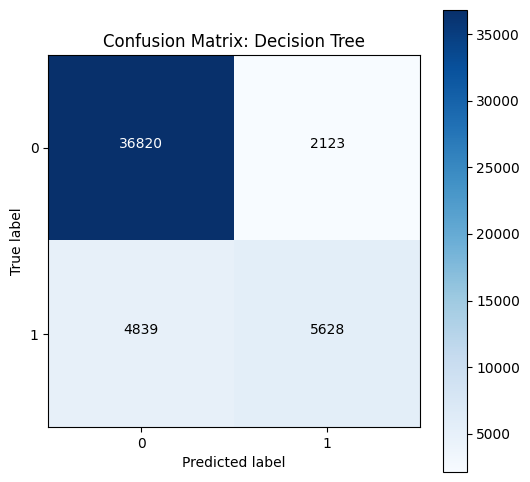

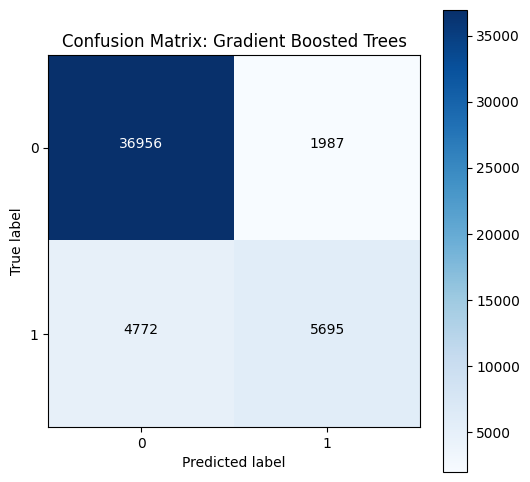

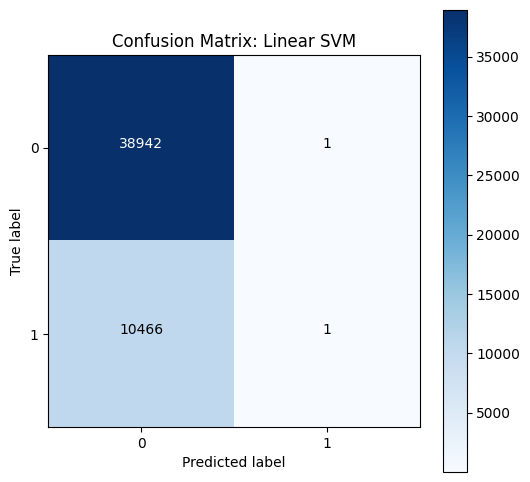

In [0]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Function to plot confusion matrix
def plot_confusion_matrix(predictions, model_name, label_col="Exited", prediction_col="prediction"):
    """
    Plots a confusion matrix for the given predictions.

    Parameters:
        predictions: The DataFrame containing the predictions.
        model_name: The name of the model (used for labeling the plot).
        label_col: The column containing the true labels.
        prediction_col: The column containing the predicted labels.
    """
    # Compute confusion matrix values
    tp = predictions.filter((col(label_col) == 1) & (col(prediction_col) == 1)).count()
    tn = predictions.filter((col(label_col) == 0) & (col(prediction_col) == 0)).count()
    fp = predictions.filter((col(label_col) == 0) & (col(prediction_col) == 1)).count()
    fn = predictions.filter((col(label_col) == 1) & (col(prediction_col) == 0)).count()

    # Create confusion matrix
    cm = [[tn, fp], [fn, tp]]

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.colorbar()
    classes = ["0", "1"]
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Add text annotations
    thresh = max(max(cm)) / 2.0
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, format(cm[i][j], "d"),
                     horizontalalignment="center",
                     color="white" if cm[i][j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

# Plot confusion matrices for all models
# Logistic Regression
plot_confusion_matrix(lr_results["predictions"], model_name="Logistic Regression")

# Random Forest
plot_confusion_matrix(rfc_results["predictions"], model_name="Random Forest")

# Decision Tree
plot_confusion_matrix(dtc_results["predictions"], model_name="Decision Tree")

# Gradient Boosted Trees
plot_confusion_matrix(gbt_results["predictions"], model_name="Gradient Boosted Trees")

# Linear SVM
plot_confusion_matrix(lsvc_results["predictions"], model_name="Linear SVM")


In [0]:
from pyspark.ml.functions import vector_to_array

def extract_roc_data(predictions, label_col="Exited", probability_col="probability"):
    """
    Extracts TPR and FPR for plotting ROC curve.
    """
    try:
        # Convert vector to array and extract class 1 probability
        predictions_with_probabilities = predictions.withColumn(
            "class_1_probability", vector_to_array(col(probability_col))[1]
        )

        # Extract true labels and predicted probabilities
        roc_data = predictions_with_probabilities.select(
            col("class_1_probability").alias("probability"),
            col(label_col).alias("label")
        ).rdd

        # Compute TPR and FPR
        roc_points = roc_data.map(lambda row: (float(row["probability"]), float(row["label"]))) \
                             .sortByKey(ascending=False) \
                             .collect()

        thresholds = [point[0] for point in roc_points]
        labels = [point[1] for point in roc_points]

        tpr = []
        fpr = []
        tp, fp = 0, 0
        total_positives = sum(labels)
        total_negatives = len(labels) - total_positives

        for i in range(len(thresholds)):
            if labels[i] == 1:
                tp += 1
            else:
                fp += 1

            tpr.append(tp / total_positives if total_positives > 0 else 0)
            fpr.append(fp / total_negatives if total_negatives > 0 else 0)

        return fpr, tpr
    except Exception as e:
        print(f"Error extracting ROC data: {e}")
        return None, None

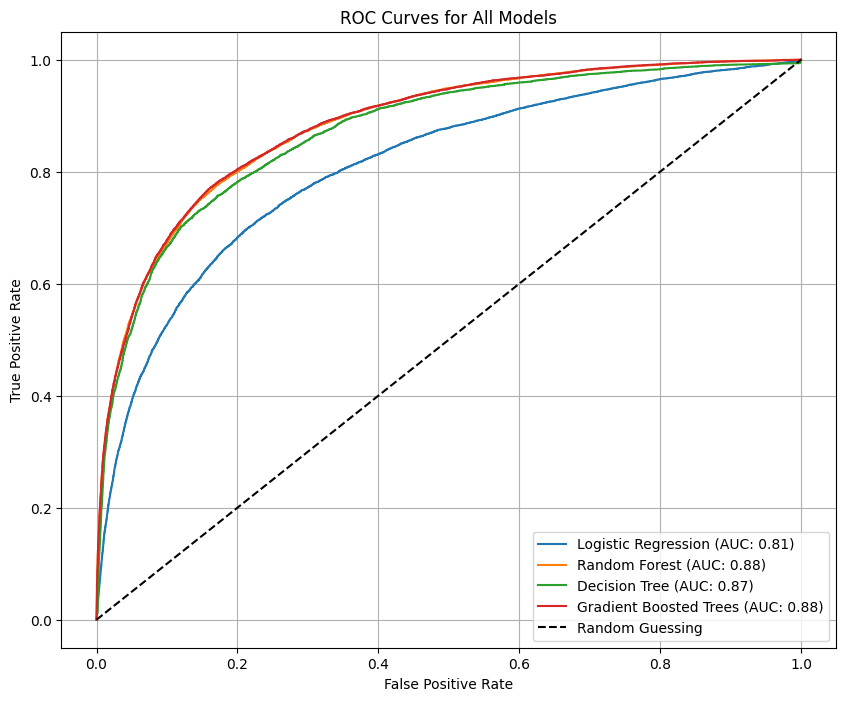

In [0]:
import matplotlib.pyplot as plt

def plot_roc_curves(models_predictions, model_names):
    """
    Plots ROC curves for multiple models.
    """
    plt.figure(figsize=(10, 8))

    for predictions, model_name in zip(models_predictions, model_names):
        if "probability" in predictions.columns:
            fpr, tpr = extract_roc_data(predictions)
            if fpr is not None and tpr is not None:
                auc = BinaryClassificationEvaluator(labelCol="Exited", rawPredictionCol="probability", metricName="areaUnderROC").evaluate(predictions)
                plt.plot(fpr, tpr, label=f"{model_name} (AUC: {auc:.2f})")
            else:
                print(f"Skipping ROC curve for {model_name} due to extraction issues.")
        else:
            print(f"Skipping {model_name}: No 'probability' column available.")

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
    plt.title("ROC Curves for All Models")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# List of predictions DataFrames and model names
models_predictions = [
    lr_results["predictions"],
    rfc_results["predictions"],
    dtc_results["predictions"],
    gbt_results["predictions"]
]
model_names = [
    "Logistic Regression",
    "Random Forest",
    "Decision Tree",
    "Gradient Boosted Trees"
]

# Plot ROC curves for all models
plot_roc_curves(models_predictions, model_names)